In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import os
import time
from IPython.core.display import clear_output
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import lmfit
import functools


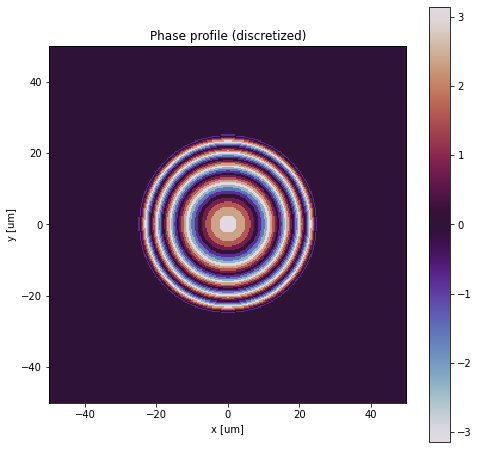

In [2]:
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

lam = 660 * nm # wavelength
r = 50 * um # aperture radius
f = 0.1 * mm # focal length
D = 0.5 * r

dim = (int(r//lam * 4), int(r//lam * 4))

x = np.linspace(-r, r, dim[0])
y = np.linspace(-r, r, dim[1])
X, Y = np.meshgrid(x, y) 
k = 2 * np.pi / lam # wave number

step = 8
# round phase to nearest 2pi/step
round = lambda phase: np.round(phase * step / (2 * np.pi)) * (2 * np.pi / step)

phase = -k * np.sqrt(X**2 + Y**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
# phase = k * X
# phase = np.ones(dim)
# gaussian = np.exp(-((X**2 + Y**2) / (2 * D**2)))
gaussian = 1
A = gaussian * np.exp(1j * phase)
A[(X**2 + Y**2) > D**2] = 0

# plt.figure(figsize=(10, 10))
# plt.imshow(np.abs(A))
# plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(np.angle(A), cmap='twilight', interpolation='nearest', extent=[min(x)/um,max(x)/um,min(y)/um,max(y)/um])
plt.colorbar()
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title('Phase profile (discretized)')
plt.show()

# perform 2d fft
# Ak = np.fft.fft2(A)

# kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
# ky = np.fft.fftfreq(len(y), np.diff(y)[0]) * 2 * np.pi
# KX, KY = np.meshgrid(kx, ky)

# for z in np.linspace(0, 2 * f, 6 + 1):
#     H = np.exp(1j * z * np.emath.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
#     E = np.fft.ifft2(Ak * H)

#     # plot the result
#     plt.figure(figsize=(10, 10))
#     plt.imshow(np.abs(E)**2, vmax=2, interpolation='nearest')
#     plt.colorbar()
#     plt.title(f'z = {z / cm} cm')
#     plt.show()

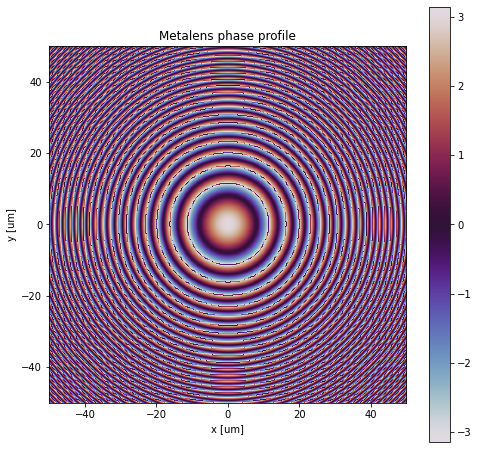

In [3]:
phase = -k * np.sqrt(X**2 + Y**2 + f**2)
# phase = np.mod(round(phase), 2 * np.pi)
gaussian = 1
A = gaussian * np.exp(1j * phase)
# A[(X**2 + Y**2) > D**2] = 0

# plt.figure(figsize=(10, 10))
# plt.imshow(np.abs(A))
# plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(np.angle(A), cmap='twilight', extent=[min(x)/um,max(x)/um,min(y)/um,max(y)/um])
plt.colorbar()
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title('Metalens phase profile')
plt.show()


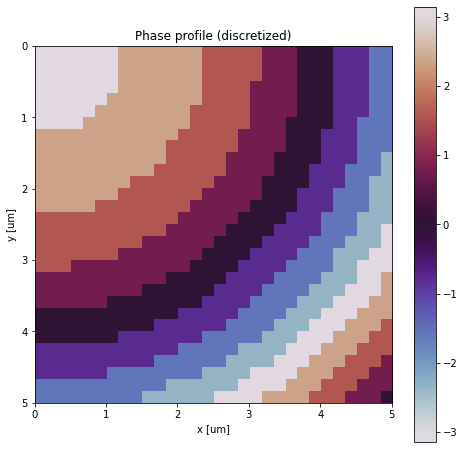

In [87]:
phase = -k * np.sqrt(X**2 + Y**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
# phase = k * X
# phase = np.ones(dim)
# gaussian = np.exp(-((X**2 + Y**2) / (2 * D**2)))
gaussian = 1
A = gaussian * np.exp(1j * phase)
A[(X**2 + Y**2) > D**2] = 0

plt.figure(figsize=(8, 8))
plt.imshow(np.angle(A)[dim[0]//2:dim[0]//2+30, dim[1]//2:dim[1]//2+30], cmap='twilight', interpolation='nearest', 
    extent=[0, r*30/dim[0]/um, r*30/dim[1]/um, 0]
    )
plt.colorbar()
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title('Phase profile (discretized)')
plt.show()



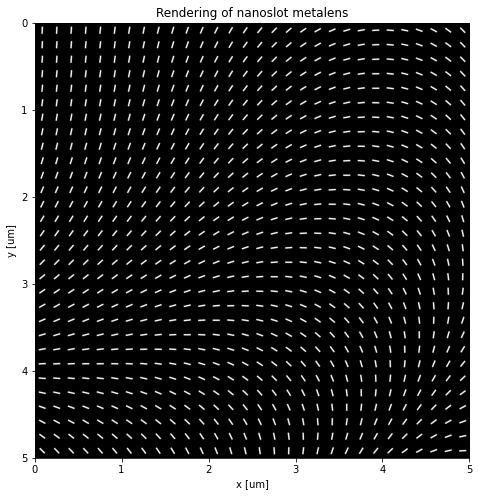

In [115]:
from metaimfit import SlotModel

res = (100, 100)
meta_x = np.linspace(-r/dim[0], r/dim[0], res[0], dtype=np.ndarray)
meta_y = np.linspace(-r/dim[1], r/dim[1], res[1], dtype=np.ndarray)
meta_X, meta_Y = np.meshgrid(meta_x, meta_y)

@functools.lru_cache
def slot(t):
    return SlotModel.gaussian_slot(meta_Y, meta_X, cy=0, cx=0, t=pi/2+t/2, l=r/dim[0], w=r/dim[1]/5, r=0.001*um)

def make_meta(phase):
    meta = np.zeros(np.multiply(res, phase.shape))
    for i, p in np.ndenumerate(phase):
        meta[i[0]*res[0]:(i[0]+1)*res[0], i[1]*res[1]:(i[1]+1)*res[1]] = slot(p)
    return meta

meta = make_meta(phase[dim[0]//2:dim[0]//2+30, dim[1]//2:dim[1]//2+30])
plt.figure(figsize=(8, 8))
plt.imshow(meta, cmap='gray', extent=[
    0, r*meta.shape[0]/res[0]/dim[0]/um, r*meta.shape[1]/res[1]/dim[1]/um, 0])
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title('Rendering of nanoslot metalens')
plt.show()


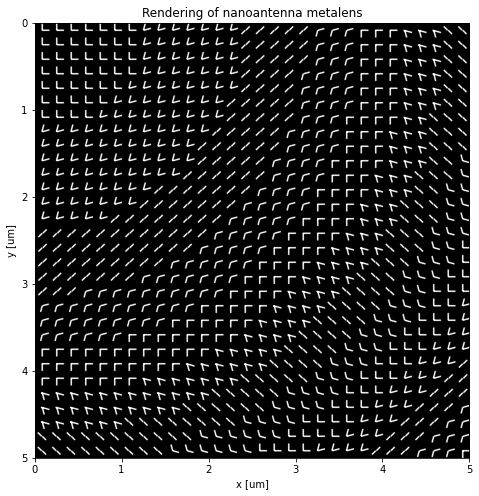

In [89]:
from metaimfit import SlotModel
from math import sin, cos

res = (100, 100)
meta_x = np.linspace(-r/dim[0], r/dim[0], res[0], dtype=np.ndarray)
meta_y = np.linspace(-r/dim[1], r/dim[1], res[1], dtype=np.ndarray)
meta_X, meta_Y = np.meshgrid(meta_x, meta_y)

l=r/dim[0]
w=r/dim[1]/5
s=0.001*um

@functools.lru_cache
def slot(t):
    if 2*pi-pi/4-pi/8 < t < 2*pi-pi/4+pi/8:
        l0 = 1.35*l
        t1 = pi/4 - pi/6
        t2 = pi/4 + pi/6
    elif -pi/8 < t < pi/8 or 2*pi-pi/8 < t < 2*pi+pi/8:
        l0 = 1.12*l
        t1 = pi/4 - pi/4
        t2 = pi/4 + pi/4
    elif (pi/4 - pi/8) < t < (pi/4 + pi/8):
        l0 = 0.90*l
        t1 = pi/4 - pi/3
        t2 = pi/4 + pi/3
    elif (2*pi/4 - pi/8) < t < (2*pi/4 + pi/8):
        l0 = 0.75*l
        t1 = pi/4 - pi/2
        t2 = pi/4 + pi/2        
    elif (3*pi/4 - pi/8) < t < (3*pi/4 + pi/8):
        l0 = 1.35*l
        t1 = 3*pi/4 - pi/6
        t2 = 3*pi/4 + pi/6
    elif (4*pi/4 - pi/8) < t < (4*pi/4 + pi/8):
        l0 = 1.12*l
        t1 = 3*pi/4 - pi/4
        t2 = 3*pi/4 + pi/4
    elif (5*pi/4 - pi/8) < t < (5*pi/4 + pi/8):
        l0 = 0.90*l
        t1 = 3*pi/4 - pi/3
        t2 = 3*pi/4 + pi/3
    elif (6*pi/4 - pi/8) < t < (6*pi/4 + pi/8):
        l0 = 0.75*l
        t1 = 3*pi/4 - pi/2
        t2 = 3*pi/4 + pi/2
    else:
        print(t)
    s1 = SlotModel.gaussian_slot(meta_Y, meta_X, cy=l0/2*cos(t1), cx=l0/2*sin(t1), t=t1, l=l0, w=w, r=s)
    s2 = SlotModel.gaussian_slot(meta_Y, meta_X, cy=l0/2*cos(t2), cx=l/2*sin(t2), t=t2, l=l0, w=w, r=s)
    return s1 + s2

def make_meta(phase):
    meta = np.zeros(np.multiply(res, phase.shape))
    for i, p in np.ndenumerate(phase):
        meta[i[0]*res[0]:(i[0]+1)*res[0], i[1]*res[1]:(i[1]+1)*res[1]] = slot(p)
    return meta

meta = make_meta(phase[dim[0]//2:dim[0]//2+30, dim[1]//2:dim[1]//2+30])
plt.figure(figsize=(8, 8))
plt.imshow(meta, cmap='gray', vmax=1, extent=[
    0, r*meta.shape[0]/res[0]/dim[0]/um, r*meta.shape[1]/res[1]/dim[1]/um, 0])
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title('Rendering of nanoantenna metalens')
plt.show()


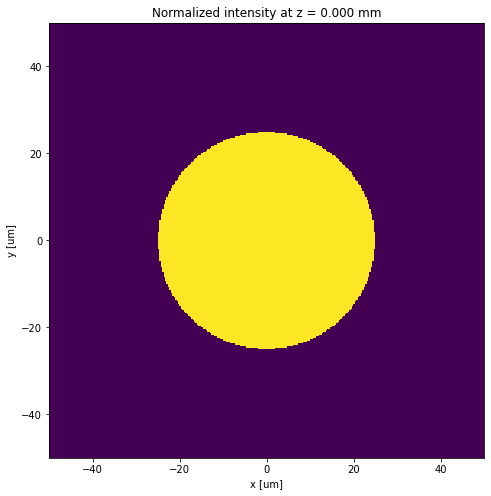

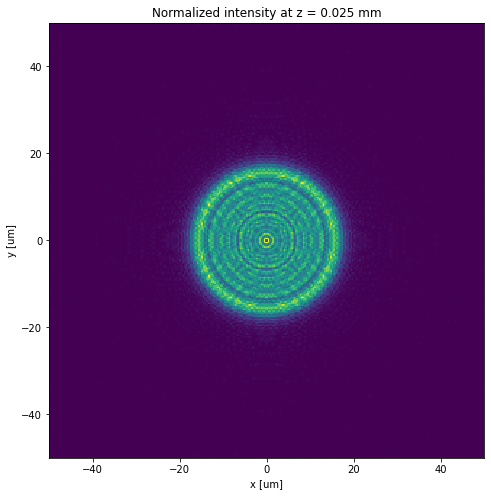

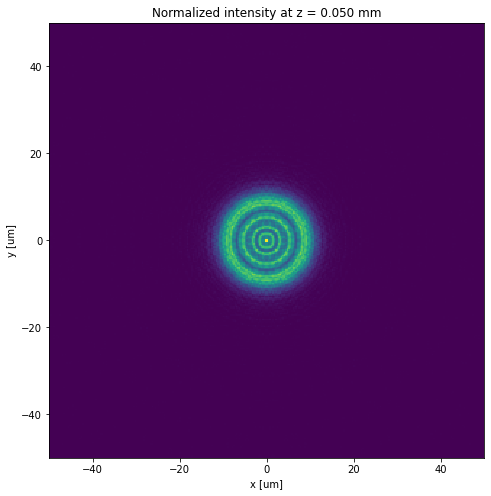

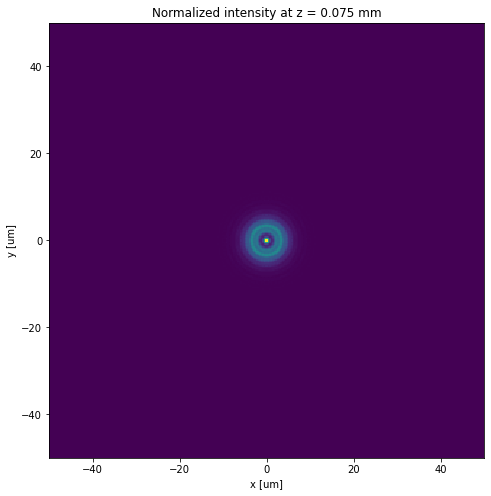

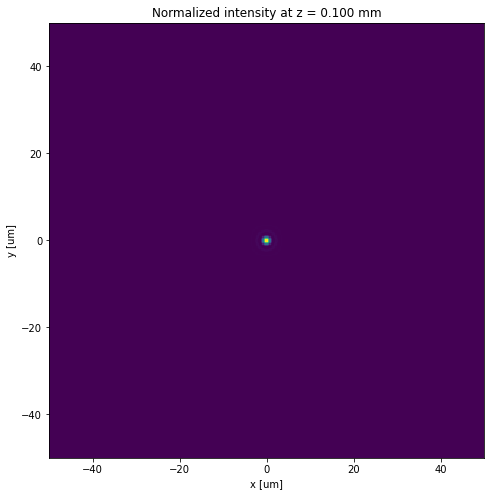

In [5]:
phase = -k * np.sqrt(X**2 + Y**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
# gaussian = np.exp(-(X**2 + Y**2) / (2 * D**2))
gaussian = 1
A = gaussian * np.exp(1j * phase)
A[(X**2 + Y**2) > D**2] = 0

Ak = np.fft.fft2(A)

kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = np.fft.fftfreq(len(y), np.diff(y)[0]) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)

for z in np.linspace(0, f, 4+1):
    H = np.exp(1j * z * np.emath.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
    E = np.fft.ifft2(Ak * H)

    # plot the result
    plt.figure(figsize=(8, 8))
    plt.imshow(np.abs(E)**2, interpolation='nearest', extent=[min(x)/um,max(x)/um,min(y)/um,max(y)/um])
    plt.xlabel('x [um]')
    plt.ylabel('y [um]')
    plt.title(f'Normalized intensity at z = {z / mm:.3f} mm')
    plt.show()

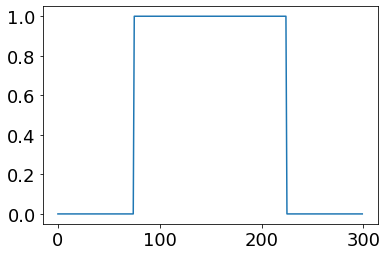

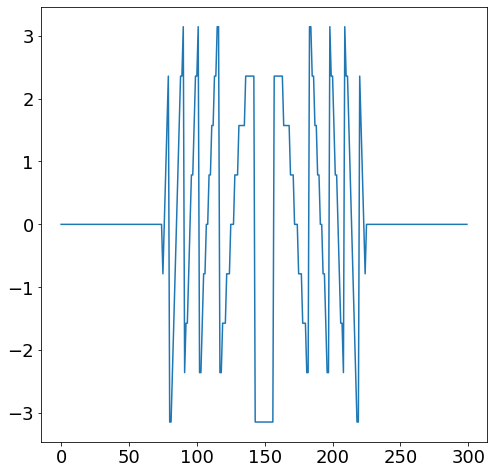

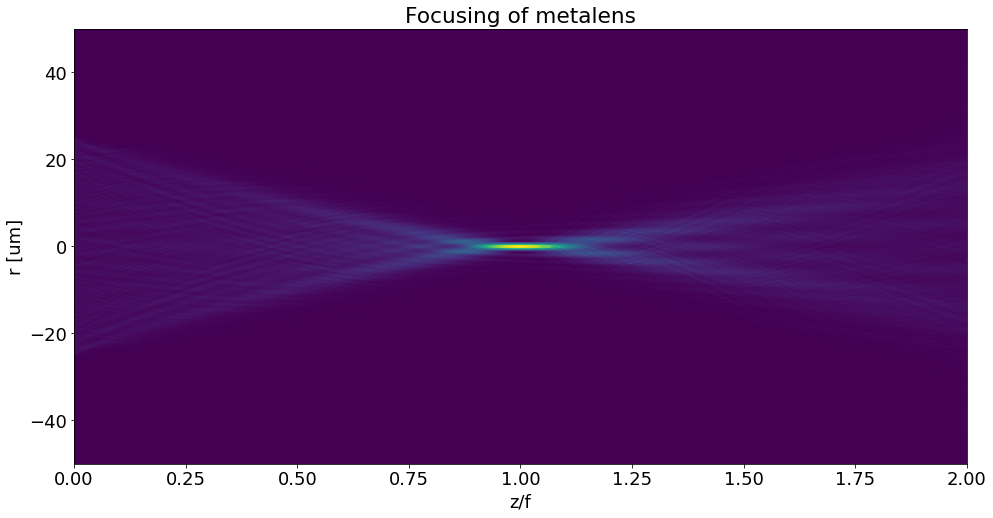

In [19]:
phase = -k * np.sqrt(X[0]**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
# gaussian = np.exp(-(X[0]**2 + f**2) / (2 * D**2))
gaussian = 1
A = gaussian * np.exp(1j * phase)
A[(X[0]**2) > D**2] = 0

# plt.figure(figsize=(8, 8))
plt.plot(np.abs(A))
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(np.angle(A))
plt.show()

Ak = np.fft.fft(A)

intensity = []
Z = np.linspace(0, 2 * f, 600 + 1)

for z in Z:
    H = np.exp(1j * z * np.emath.sqrt(k**2 - np.abs(KX[0])**2))
    E = np.fft.ifft(Ak * H)
    intensity.append(np.abs(E)**2)


intensity = np.array(intensity).T
plt.figure(figsize=(16, 8))
plt.imshow(intensity, aspect='auto', extent=[0, Z[-1]/f, -r/um, r/um])
plt.xlabel('z/f')
plt.ylabel('r [um]')
# plt.colorbar()
plt.title('Focusing of metalens')
plt.show()
        

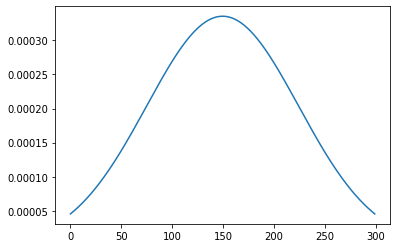

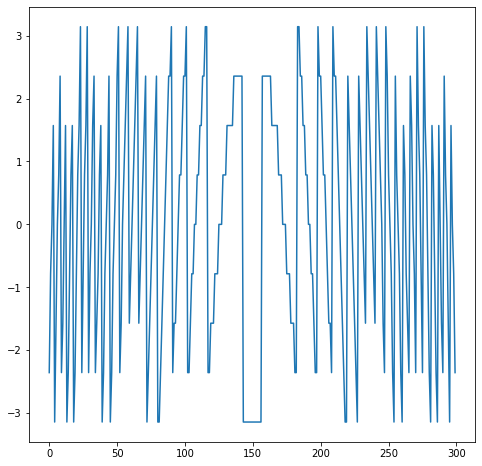

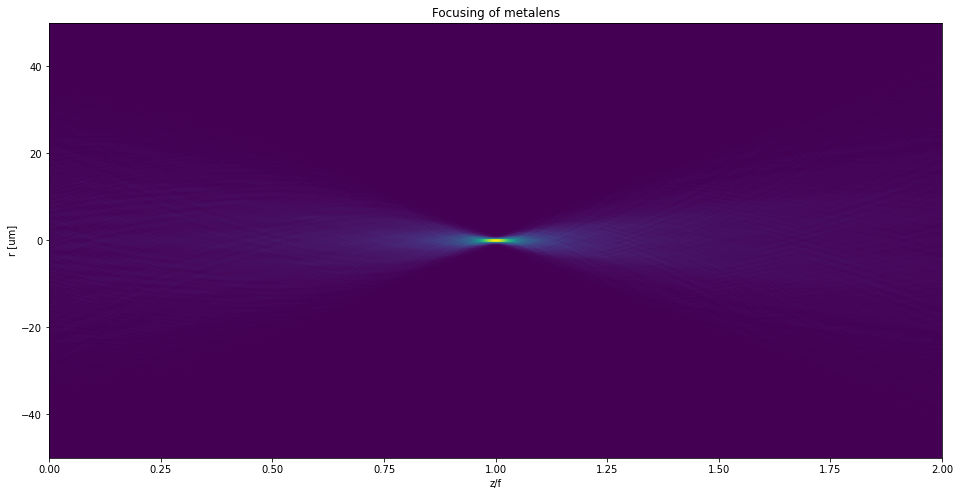

In [6]:
step = 8
# round phase to nearest 2pi/step
round = lambda phase: np.round(phase * step / (2 * np.pi)) * (2 * np.pi / step)

phase = -k * np.sqrt(X[0]**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
gaussian = np.exp(-(X[0]**2 + f**2) / (2 * D**2))
# gaussian = 1
A = gaussian * np.exp(1j * phase)
# A[(X[0]**2) > D**2] = 0

# plt.figure(figsize=(8, 8))
plt.plot(np.abs(A))
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(np.angle(A))
plt.show()

Ak = np.fft.fft(A)

intensity = []
Z = np.linspace(0, 2 * f, 600 + 1)

for z in Z:
    H = np.exp(1j * z * np.emath.sqrt(k**2 - np.abs(KX[0])**2))
    E = np.fft.ifft(Ak * H)
    intensity.append(np.abs(E)**2)


intensity = np.array(intensity).T
plt.figure(figsize=(16, 8))
plt.imshow(intensity, aspect='auto', extent=[0, Z[-1]/f, -r/um, r/um])
plt.xlabel('z/f')
plt.ylabel('r [um]')
# plt.colorbar()
plt.title('Focusing of metalens')
plt.show()
    

In [14]:
import matplotlib

font = {'size'   : 18}

matplotlib.rc('font', **font)


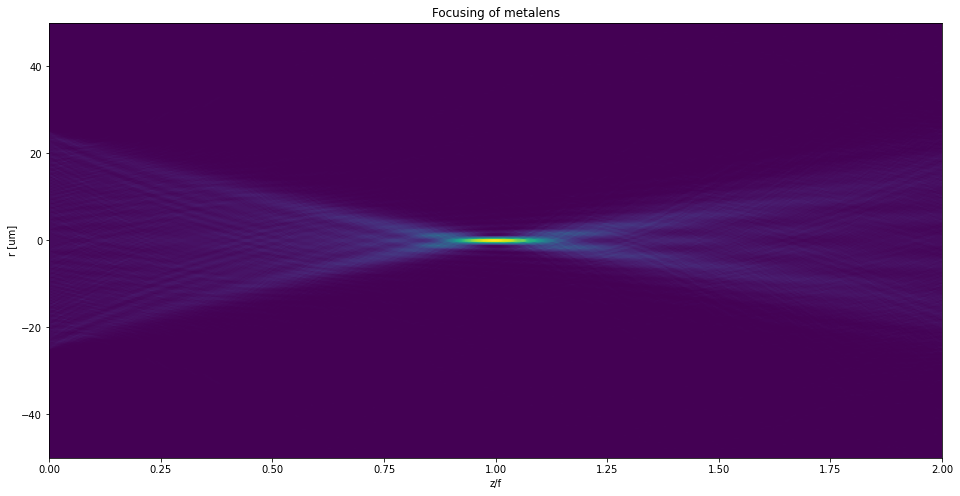

In [7]:
phase = -k * np.sqrt(X[0]**2 + f**2)
phase = np.mod(round(phase), 2 * np.pi)
# gaussian = np.exp(-(X[0]**2 + f**2) / (2 * D**2))
gaussian = 1
A = gaussian * np.exp(1j * phase)
A[(X[0]**2) > D**2] = 0 # add aperture if needed

Ak = np.fft.fft(A)

intensity = []
Z = np.linspace(0, 2 * f, 600 + 1)

for z in Z:
    H = np.exp(1j * z * np.emath.sqrt(k**2 - np.abs(KX[0])**2))
    E = np.fft.ifft(Ak * H)
    intensity.append(np.abs(E)**2)


intensity = np.array(intensity).T
plt.figure(figsize=(16, 8))
plt.imshow(intensity, aspect='auto', extent=[0, Z[-1]/f, -r/um, r/um])
plt.xlabel('z/f')
plt.ylabel('r [um]')
# plt.colorbar()
plt.title('Focusing of metalens')
plt.show()
        